# Create climate dataset for capitals in Europe

In [27]:
import xarray as xr
import matplotlib.pyplot as plt
import cfgrib
import pandas as pd
import numpy as np
%matplotlib inline

# to resolve xarray FutureWarning
xr.set_options(use_new_combine_kwarg_defaults=True)

In [ ]:
# Check all available datasets first
eu_capitals = pd.read_csv("datasets/eu_capitals.csv")
eu_capitals.head()

,name,latitude,longitude
0,Mariehamn,60.00,20.00
1,Tirana,41.25,19.75
2,Andorra la Vella,42.50,1.50
3,Yerevan,40.25,44.50
4,Vienna,48.25,16.25


In [83]:
bern = eu_capitals[eu_capitals['name'] == 'Bern']
display(bern)

,name,latitude,longitude
53,Bern,47.0,7.5


In [70]:
# Check all available datasets first
all_datasets = cfgrib.open_datasets("1970_2020.grib")
print(f"Number of datasets: {len(all_datasets)}\n")

for i, dataset in enumerate(all_datasets):
    print(f"Dataset {i}:")
    print(f"  Variables: {list(dataset.data_vars)}")
    print(f"  Dimensions: {dict(dataset.sizes)}")

Number of datasets: 2

Dataset 0:
  Variables: ['sf', 'tp']
  Dimensions: {'time': 612, 'latitude': 149, 'longitude': 281}
Dataset 1:
  Variables: ['t2m', 'si10']
  Dimensions: {'time': 612, 'latitude': 149, 'longitude': 281}


In [ ]:
all_datasets = cfgrib.open_datasets("1970_2020.grib")

# Dataset 0 contains: sf, tp
# Dataset 1 contains: t2m, si10
# Each dictionary entry is a cube
ds = {
    'sf': all_datasets[0].sf,
    'tp': all_datasets[0].tp,
    't2m': all_datasets[1].t2m,
    'si10': all_datasets[1].si10
}

print("Loaded variables:", list(ds.keys()))
print(f"Dimensions: time={len(all_datasets[0].time)}, lat={len(all_datasets[0].latitude)}, lon={len(all_datasets[0].longitude)}")

Loaded variables: ['sf', 'tp', 't2m', 'si10']
Dimensions: time=612, lat=149, lon=281


In [37]:
features = ["sf", "t2m", "tp", "si10"]

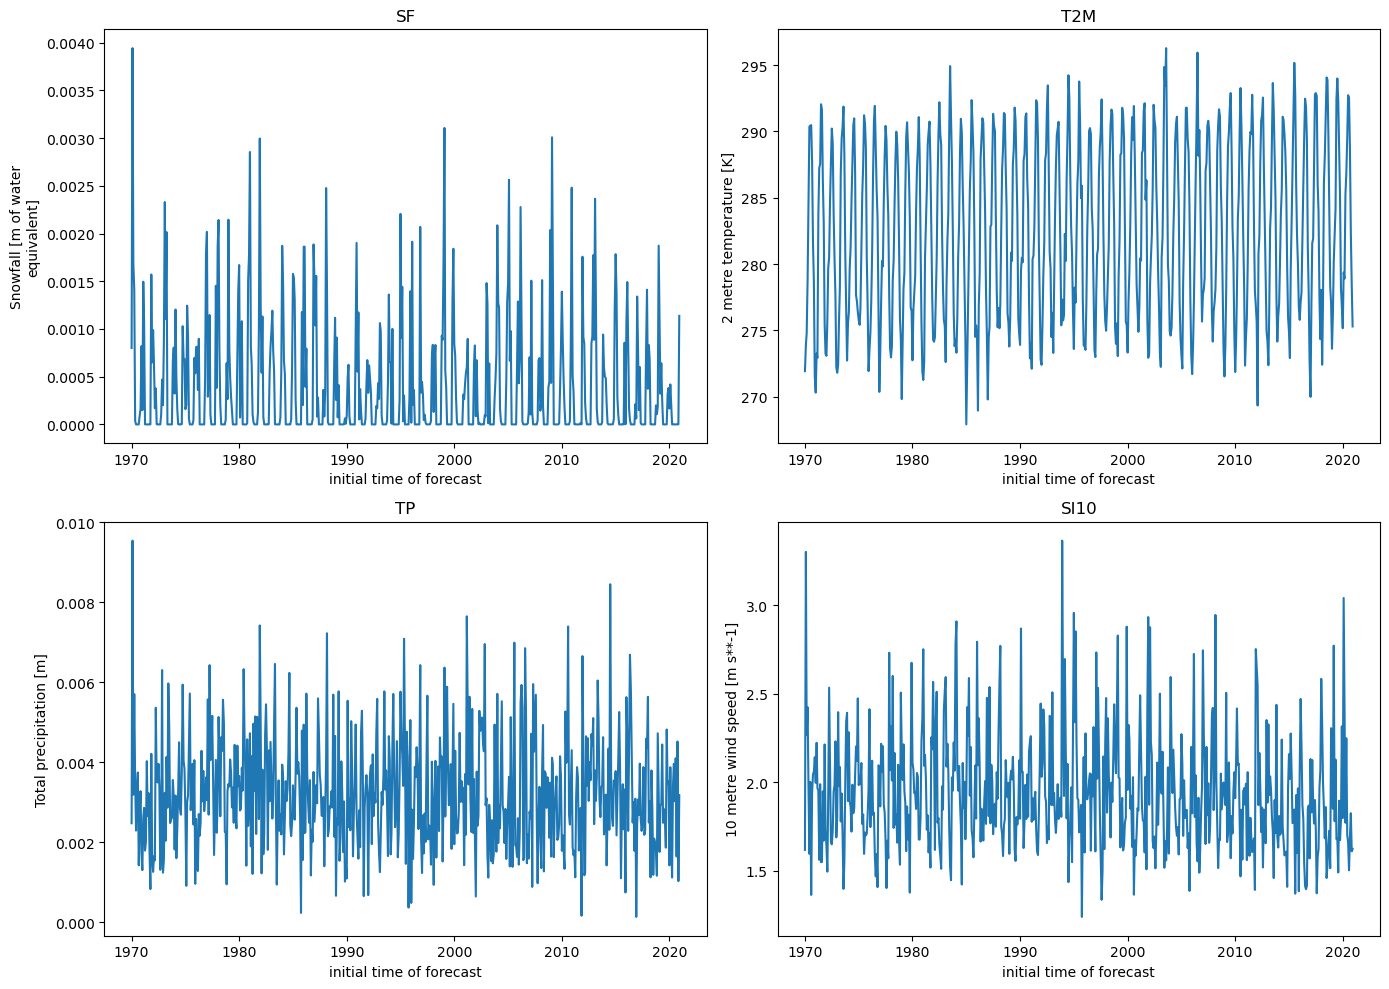

In [ ]:
# Plot time series for each feature at Bern's location

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feat in enumerate(features):
    ds[feat].sel(longitude=bern.longitude.values[0], latitude=bern.latitude.values[0]).plot(ax=axes[i])
    axes[i].set_title(f'{feat.upper()}')

plt.tight_layout()
plt.show()

In [103]:
ds["sf"].sel(longitude=bern.longitude.values[0], latitude=bern.latitude.values[0])

<xarray.DataArray 'sf' (time: 612)> Size: 2kB
[612 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 5kB 1969-12-31T18:00:00 ... 2020-11-30T...
    number      int64 8B 0
    step        timedelta64[ns] 8B 12:00:00
    surface     float64 8B 0.0
    latitude    float64 8B 47.0
    longitude   float64 8B 7.5
    valid_time  (time) datetime64[ns] 5kB ...
Attributes: (12/31)
    GRIB_paramId:                             144
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      41869
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgad
    ...                                       ...
    GRIB_shortName:                           sf
    GRIB_totalNumber:                         0
    GRIB_units:                               m of water equivalent
    long_name:                                Snowfall
    units:                                    m of water equivalent
    standard_name:                            lwe_thickness_of_snowfall_amount

In [142]:
# Keep only the data linked to the european capitals

eu_capitals_sorted = eu_capitals.sort_values(['latitude', 'longitude'])

# Extract coordinates as arrays
lats = eu_capitals_sorted['latitude'].values
lons = eu_capitals_sorted['longitude'].values
names = eu_capitals_sorted['name'].values

# Create a subset of ds with only the capitals' coordinates
ds_capitals = {}

for feat in features:
    # Select all capitals at once
    ds_capitals[feat] = ds[feat].sel(
        latitude=xr.DataArray(lats, dims='latitude'),
        longitude=xr.DataArray(lons, dims='longitude'),
        method='nearest'
    )

# Verify
print(f"Original dimensions: {ds['t2m'].dims}")
print(f"Original shape: {ds['t2m'].shape}")
print(f"Subset dimensions: {ds_capitals['t2m'].dims}")
print(f"Subset shape: {ds_capitals['t2m'].shape}")

# You can access data by capital name
print(f"\nData for first capital ({eu_capitals.iloc[0]['name']}):")
print(f"Latitude: {ds_capitals['t2m'].latitude.values[0]}")
print(f"Longitude: {ds_capitals['t2m'].longitude.values[0]}")

Original dimensions: ('time', 'latitude', 'longitude')
Original shape: (612, 149, 281)
Subset dimensions: ('time', 'latitude', 'longitude')
Subset shape: (612, 58, 58)

Data for first capital (Mariehamn):
Latitude: 35.25
Longitude: 33.25


In [ ]:
# We see that we still have 612 time steps for 58 lat/lon = capitals
ds_capitals["t2m"]

<xarray.DataArray 't2m' (time: 612, latitude: 58, longitude: 58)> Size: 8MB
[2058768 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2020-12-01
  * latitude    (latitude) float64 464B 35.25 35.25 36.0 ... 62.0 64.25 72.0
  * longitude   (longitude) float64 464B 33.25 33.25 14.5 ... -6.75 -22.0 15.75
    number      int64 8B 0
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 5kB ...
Attributes: (12/31)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      41869
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown

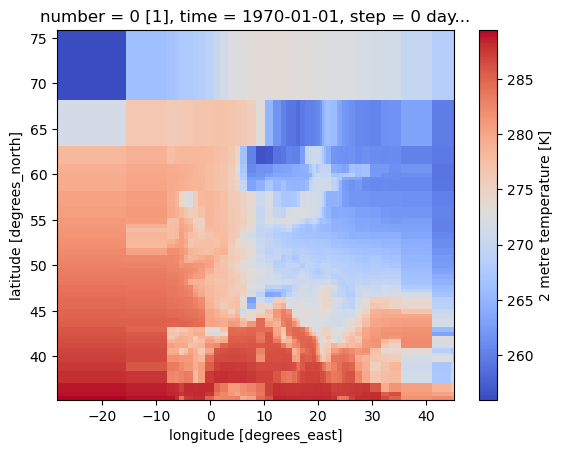

In [ ]:
# Plot the temperature data for the first time step across all capitals
ds_capitals["t2m"][0].sortby(['latitude', 'longitude']).plot(cmap=plt.cm.coolwarm)

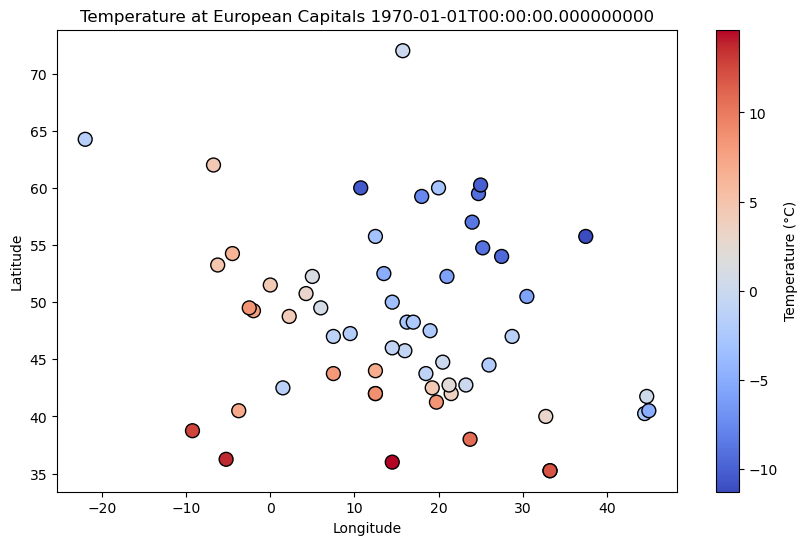

In [38]:
plt.figure(figsize=(10, 6))

# Extract the diagonal values (matching lat/lon pairs)
temps = np.diag(ds_capitals["t2m"][0].values) - 273.15  # Convert Kelvin to Celsius
lats = ds_capitals["t2m"].latitude.values
lons = ds_capitals["t2m"].longitude.values

plt.scatter(lons, lats, c=temps, cmap=plt.cm.coolwarm, s=100, edgecolors='black')
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Temperature at European Capitals {ds_capitals["t2m"].time.values[0]}')
plt.show()

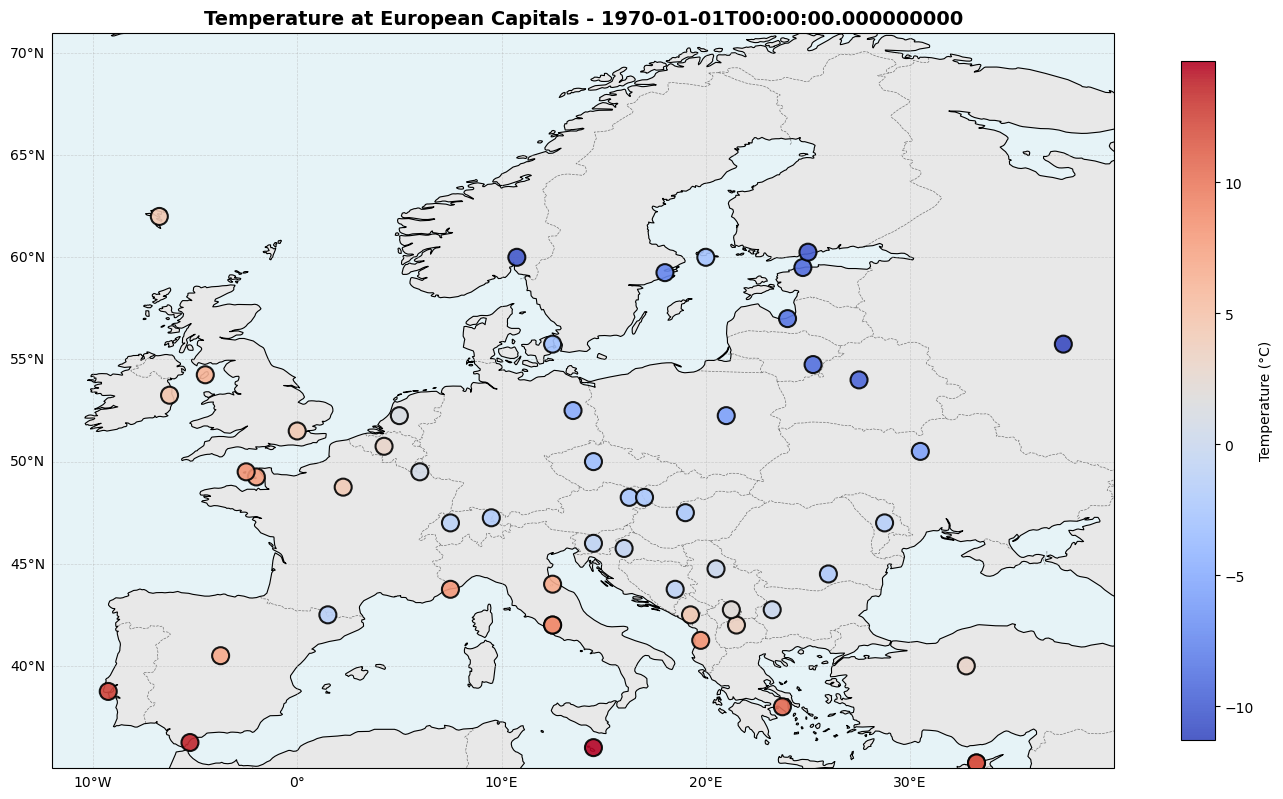

In [41]:
# Enhanced plot with Cartopy for better geographical representation

import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Extract the diagonal values (matching lat/lon pairs)
temps = np.diag(ds_capitals["t2m"][0].values) - 273.15  # Convert Kelvin to Celsius
lats = ds_capitals["t2m"].latitude.values
lons = ds_capitals["t2m"].longitude.values

# Plot scatter with correct transform
scatter = ax.scatter(lons, lats, c=temps, cmap='coolwarm', s=150, 
                        edgecolors='black', linewidths=1.5, 
                        transform=ccrs.PlateCarree(), zorder=5, alpha=0.9)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Temperature (°C)', shrink=0.7, pad=0.05)

# Set extent to focus on Europe (West, East, South, North)
ax.set_extent([-12, 40, 35, 71], crs=ccrs.PlateCarree())

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title(f'Temperature at European Capitals - {ds_capitals["t2m"].time.values[0]}', 
                fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

For each feature, for each capital (lat,lon), do the mean on 10 years for each month 